In [1]:
""" PSM_Processing.ipynb

This notebook layout the processing pipeline for analysing the propagation
speed, and embrynic width of PSMs.

Note: This notebook is exposed as a module for larger scale parameter studies.
It was decided not to refactor the notebook into modules, as the defintion of
the functions provides the motivation and story for processing PSMs. For an
example of how this might be used in larger scale instances, refer to
`parameter_study.py`"""

%load_ext notebook_helpers
imported = (not __name__ == "__main__")
## use %load_ext nb_black, to run the yapf chromium formatter

In [2]:
from PSMProcessing import ProcessContext

import glob
from collections import OrderedDict, namedtuple
import warnings
import numpy as np
import scipy.ndimage
from skimage import feature as ski_feature
from skimage.transform import resize as rs
import imageio

from scipy.stats import probplot, norm
import pylab

import multiprocessing
import matplotlib.pyplot as plt

In [3]:
"""Global definitions and variables for a given run."""

# Global cache of images and data, initialized to be empty here..
images = {}
cube = np.array([[[]]])
times = []

# Run specific variables
experiment = 32  # The experiment number. Images for this experiment should be in folder {experiment}/
band = 3  # The band to examine within the experiment
export_gifs = True  # Whether gifs should be exported
interactive = True  # Whether interactive parts of the script should be run.
recompute = False  # Forces recomputation. Warning, will potentially overwrite
                   # other variables.

# Experiment specific variables. These will be overwritten
# if the experiment has already been analyzed.
scale = 768 / 40.27  # Pixels to um ratio.
frequency = 75  # The frequency of loading
direction = 2. / 3  # The slope of the PSBs in the experiment relative to the image.
                    # Seemingly allows for margin of error.
beam_height = 600  # In pixels
beam_width = 180  # in pixels
flip = True  # All PSB slope should be positive. If the slope is negative, a
             # reflection is performed on the picture.

# Band specific variables
start = 0  # The start offset of a given band.
width = beam_height  # The width of the given band.

# New experiment specific variables. These values will be ignored
# unless no records exist for the given variable.
# Image loading specific variables.
resize = 0  # Scale factor by which the image should be resized. Set 0 for no resizing.
borders = [50, 140, 30, 40]  # Left, Right, Top, Bottom.
                             # Cropping margins for the processed images.
margin_x = [20, 3]  # The margin to provide a partially cropped beam,
                    # when determining how to crop the height

# Event capture specific variables.
time_margin = 15  # How much of the video to ignore at the beginning and end
sigma = 0.65  # Smoothing deviation for filtering procedures

In [4]:
# Load records if possible.
Record = namedtuple("Record", ("scale frequency direction sigma "
                               "beam_height beam_width flip time_margin bands"))
Band = namedtuple("Band", ("start width lower upper"))

# Globals associated with each experiment analysis.
# Update this variable accordingly with each analysis performed.
# The currently set data is particular to our experimental data.
experiments = {
    32:
        Record(
            scale=768. / 42.4,
            frequency=75,
            direction=2. / 3,
            sigma=0.65,
            beam_height=575,
            beam_width=270,
            flip=False,
            time_margin=15,
            bands={
                2: Band(195, 35, 2.5, 9.5),
                3: Band(252, 30, 3, 7.5),
                5: Band(315, 30, 2.5, 7.5),
                8: Band(390, 30, 8, 12.5),
            }),
    24:
        Record(
            scale=768. / 45.43,
            frequency=75,
            direction=.5,
            sigma=0.65,
            beam_height=500,
            beam_width=200,
            flip=True,
            time_margin=60,
            bands={
                2: Band(480, 25, 9, 11),
                3: Band(465, 20, 0, 0),
                4: Band(440, 25, 0, 0),
                5: Band(412, 25, 0, 0),
                6: Band(390, 20, 8, 9.8),
                7: Band(365, 25, 3, 11),
                8: Band(345, 20, 1, 6),
            }),
    25:
        Record(
            scale=768. / 40.27,
            frequency=75,
            direction=2. / 3,
            sigma=0.65,
            beam_height=600,
            beam_width=180,
            flip=True,
            time_margin=1,
            bands={
                7: Band(265, 35, 0, 0),
                8: Band(210, 35, 0, 0),
                9: Band(185, 25, 0, 0)
            })
}

In [5]:
%%skip $imported
# If the experiment is listed, we use the values specified by the `experiments` variable
if experiment in experiments:
  warnings.warn("Overriding definitions for records.")
  (scale, frequency, direction, sigma,
   beam_height, beam_width, flip, time_margin, bands) = experiments[experiment]
  if band in bands:
    start, width, lower, upper = bands[band]
  else:
    warnings.warn(("Band is not defined. Considering whole beam. "
                  " Please redefine `start, width` for a given band."))    
else:
  warnings.warn("Could not find record. Relying on global defintions.")

/home/dylan/results/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Overriding definitions for records.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
def extract_images(src,
                   borders=borders,
                   resize=resize,
                   margin_x=margin_x,
                   frequency=frequency,
                   beam_width=beam_width,
                   beam_height=beam_height):
  """Extracts a PSB from an image based on lighting hueristics.
  
  Given a beam height and size, determines where the beam is most
  likely to be based on dramaticlighting changes from the background
  to foreground.
  
  Args:
      src: A file name for an expected to be of the form "path/to/image/image_timestamp.bmp" 
      borders: The cropping margins to apply to the image
      resize: The scale factor to resize the image.
      margin_x: Margins by which 

  Returns:
      A tuple of (cycle #, PSB of fixed size (beam_width x beam_height))
  """
  cycle = int(
      src.split("/")[-1].split("_")[-1].split(".")[0]) / 1000. * frequency
  image = imageio.imread(src)

  # Go from RGB -> blackwhite and cast
  image = np.rint(np.mean(image, axis=-1)).astype(np.uint8)

  # Resize using skimage.
  if resize:
    image = rs(
        image, tuple(i * resize for i in image.shape), anti_aliasing=True)

  #Crop borders form image
  image = image[borders[0]:-borders[1], borders[2]:-borders[3]]

  # Pretty reliably finds crop position where the beam occurs.
  # could do convolution like for the height.
  x = np.sum(scipy.ndimage.filters.gaussian_filter(image, 3), axis=0)
  crop_x = np.argmax(np.convolve(x.T, np.ones(beam_width, dtype=int), 'valid'))

  # Cropping for height is a little more unstable. As such, smoothing and crop
  # margins were found to help.
  smoothed = scipy.ndimage.filters.gaussian_filter(image, 3)
  smoothed = smoothed[:, crop_x - margin_x[0]:crop_x + margin_x[1]]

  # Attempts find crop position from the top of the beam
  y = np.sum(smoothed, axis=1)
  crop_y = np.argmin(np.convolve(y.T, np.ones(beam_height, dtype=int), 'valid'))

  # Apply the crop with a fixed size
  return (cycle, image[crop_y:crop_y + beam_height, crop_x:crop_x + beam_width])


def load_images(path="images",
                experiment=experiment,
                bmps="images/{}/*.bmp",
                recompute=False, **kwargs):
  try:
    if recompute:
      raise
    images = np.load("npy/{}_{}.npy".format(path, experiment),
                     allow_pickle=True).item()
  except:
    pool = multiprocessing.Pool()
    images = OrderedDict(
        sorted(pool.map(ProcessContext(
          extract_images, **kwargs), glob.glob(bmps.format(experiment)))))
    pool.close()
    del pool
    np.save("npy/{}_{}".format(path, experiment), images)
  return images

In [7]:
%%skip $imported
# Extract or load the images relevant to the experiment.
images = load_images(recompute=recompute)
beam_height, beam_width = images[list(images.keys())[0]].shape
times = list(images.keys())
image = images[times[-1]]

In [8]:
"""Export a gif of the newly cropped images."""
if export_gifs and images:
  gif = "psb_stable_{}.gif".format(experiment)

  # We can smooth through time too!
  imageio.mimsave(
      gif,
      scipy.ndimage.filters.gaussian_filter(list(images.values()), 1),
      fps=60)

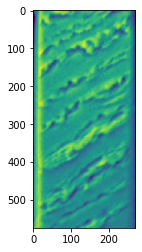

In [9]:
"""Examine the last frame of our image."""
if interactive and not imported:
  plt.imshow(scipy.ndimage.filters.gaussian_filter(image, 2))
  plt.show()

In [10]:
def determine_psb_slip_direction(image, sigma=1):
  """Run a gradient on the image for a ball park of the slip direction.
  
  Depending on how the gradient get calculated, the answer might be inverse to
  the gradient.
  
  Args:
    image: The final image in the set (has the most psbs)
    sigma: The amount of smoothing to do on the image prior to running gradient
  Returns: Image of gradients
  """
  filtered = scipy.ndimage.filters.gaussian_filter(image, sigma)
  gx, gy = np.gradient(filtered)
  return np.arctan2(gy, gx)

In [11]:
%%skip $imported
plt.close("all")
img = determine_psb_slip_direction(image, sigma=3)

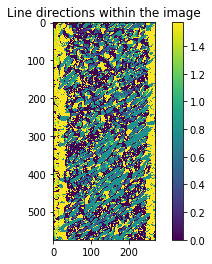

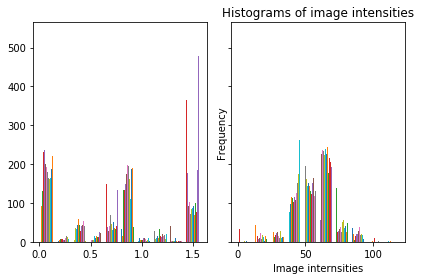

In [12]:
"""Examine gradients in image to quantatively examine the slip direction with
reference to the image."""
if interactive and not imported:
  plt.figure()
  plt.title("Line directions within the image")
  plt.imshow(img)
  plt.colorbar()
  # Run a histogram on the gradients to see what's most likely.
  plt.show()
  fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
  plt.title("Histograms of line directions")
  plt.xlabel("Line direction values")
  plt.ylabel("Frequency")
  axs[0].hist(img)
  # Histogram of general intensities
  #axs[1].title = "Histogram of image intensities."
  plt.title("Histograms of image intensities")
  plt.xlabel("Image internsities")
  plt.ylabel("Frequency")
  axs[1].hist(image)

In [13]:
"""Take direction from histogram if not already suggested."""
if not direction:
  direction = np.mean(img[np.all([img > 0.5, img < 1.], axis=0)])

In [14]:
"""Reorient our image onto the PSB direction."""


def extract_length(image_shape, direction=1):
  """Grab the lines along the slip direction for the entire image.
  
  Args:
    image_shape: shape of the images, should be [x, y, 1].
    direction: The direction of the slip plane we determined.
    
  Returns:
    A tuple of (line lengths, line directions)
  """

  sample_count = min(image_shape[:2])
  gradient = direction
  norm = np.linalg.norm

  lengths = []
  lins = []
  X = 0
  # Scan along the y axis
  for Y in range(image_shape[0]):
    # Determine whether line will be flush to the right or top of the image.
    if X + Y / gradient > image_shape[1]:
      n = norm([X - image_shape[1], image_shape[1] * gradient])
      x = np.linspace(X, image_shape[1], sample_count)
      y = np.linspace(Y, -image_shape[1] * gradient + Y, sample_count)
    else:
      n = norm([Y / gradient, Y])
      x = np.linspace(0, Y / gradient, sample_count)
      y = np.linspace(Y, 0, sample_count)
    lengths.append(n)
    lins.append(np.vstack((y, x)))

  # Keeps scanning down the y axis, but now the line starts at the bottom of
  # the image. End when line no longer is on the image.
  while -image_shape[1] * gradient + Y + X < image_shape[0]:
    # Determine whether line will be flush to the right or top of the image.
    if X + Y / gradient > image_shape[1]:
      n = norm([X / gradient - image_shape[1], image_shape[1] * gradient - X])
      x = np.linspace(X / gradient, image_shape[1], sample_count)
      y = np.linspace(Y, -image_shape[1] * gradient + Y + X, sample_count)
    else:
      n = norm([X / gradient - (X + Y) / gradient, Y])
      x = np.linspace(X / gradient, (X + Y) / gradient, sample_count)
      y = np.linspace(Y, 0, sample_count)
    X += 1
    lengths.append(n)
    lins.append(np.vstack((y, x)))

  return np.array(lengths), np.array(lins)


def extract(image, lins, flip=flip):
  """Apply calculated lines to image."""
  result = []
  if flip:
    image = np.fliplr(np.flip(image))
  for stack in lins:
    # Extract the values along the line, using cubic interpolation
    result.append(scipy.ndimage.map_coordinates(image, stack))
  return np.array(result)


if not imported:
  lengths, lins = extract_length(image.shape, direction=direction)

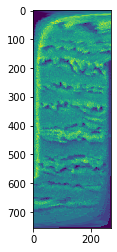

In [15]:
"""Validate that the images are properly sheared."""
if interactive and not imported:
  plt.imshow(extract(image, lins, flip=flip))
  plt.show()

In [77]:
"""Grab a particular PSB"""

# Ideally, this would be a lambda, but `processing` pickles the functions
# in map, thus the function must be global.
def _shear_images_helper(item, lins=None, **kwargs):
  key, image = item
  return (key, extract(image, lins, **kwargs))

def shear_images(images,
                recompute=False,
                path="extracted",
                experiment=experiment, **kwargs):
  try:
    if recompute:
      raise
    extracted = np.load("npy/{}_{}.npy".format(path, experiment),
                        allow_pickle=True).item()
  except:
    pool = multiprocessing.Pool()
    extracted = OrderedDict(sorted(pool.map(
      ProcessContext(_shear_images_helper, **kwargs), images.items())))
    pool.close()
    del pool
    np.save("npy/{}_{}".format(path, experiment), extracted)
  return extracted

if not imported:
  cube = np.array(
      list(shear_images(images, recompute=recompute, flip=flip, lins=lins).values())).astype(float)

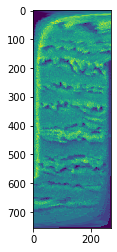

In [17]:
"""Examine the the last frame of our sheared time cube."""
if interactive and not imported:
  plt.imshow(cube[-1, :, :])
  plt.show()

In [18]:
"""Export a gif of the sheared time cube."""
if export_gifs and cube.size > 0:
  gif = "psb_stable_axis_{}.gif".format(experiment)
  imageio.mimsave(gif, cube, fps=30)

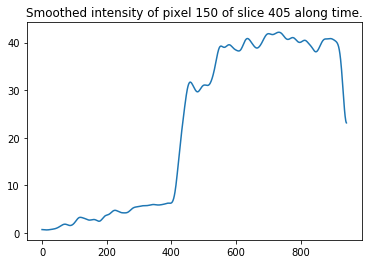

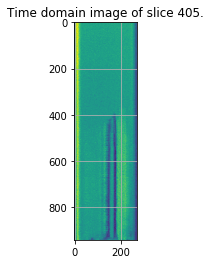

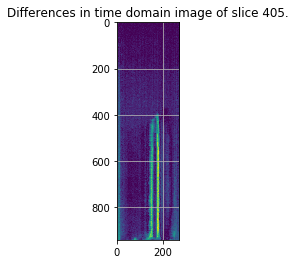

In [64]:
"""Examine intensity profiles over time. This is useful for developing event
determination algorithms."""
if interactive and not imported:
  # Checkout our time cube and various slice, in time/space
  offset = 0
  s = 405
  p = 150

  avg_profile = np.average(cube[:time_margin, s, :], axis=0)
  smoothed = scipy.ndimage.filters.gaussian_filter(np.abs(cube[:, s, :]), 1)
  smoothed_difference = np.abs(
      scipy.ndimage.filters.gaussian_filter(cube[:, s, :] - avg_profile, 1))

  # t = 180 in ex. 32 is a good example of little change
  plt.title("Smoothed intensity of pixel {} of slice {} along time.".format(
      p, offset + s))
  plt.plot(scipy.ndimage.filters.gaussian_filter(smoothed_difference[:, p], 9))
  plt.show()

  plt.title("Time domain image of slice {}.".format(offset + s))
  plt.imshow(smoothed)
  plt.grid()
  plt.show()

  plt.title("Differences in time domain image of slice {}.".format(offset + s))
  plt.imshow(smoothed_difference)
  plt.grid()
  plt.show()

In [113]:
"""Methods to extract the events from each time slice."""


def determine_event_by_KL(time_slice, margin=time_margin):
  """Determine the cycle at which an 'event' occurs, by comparing the
  distributions about a point using KL divergence."""
  # Works best for a binary distribution over the time series distributio
  .
  s = []
  for pivot in range(margin, len(time_slice) - margin):
    sP = np.std(time_slice[:pivot]) + 1e-5
    sQ = np.std(time_slice[pivot:]) + 1e-5
    P = np.mean(time_slice[:pivot])
    Q = np.mean(time_slice[pivot:])
    s.append(np.abs(
      np.log(sP/sQ) + (sQ**2 + (P - Q)**2)/(2 * sP**2) - 0.5))

  return margin + np.argmax(s)


def determine_event_by_step(time_slice, pool, margin=time_margin):
  """Determine the cycle at which an 'event' occurs. This dramatic change in signal
  should indicate a PSB propagating at this time.
  
  We note that in the case of a continuous series such as the intensity of a
  pixel through time, this works by finding the minimum point at which the standard
  deviations differ. The idea being that each segment will have low class variance,
  and as such, the difference of the deviations should be minimized.
  Not this is not robust to lighting changes over time.
  
  In the case of a discrete series, i.e. post canny-processing. We expect the frequency
  of edge detections to increase after the event. Thus the process works by finding the
  maximum spot at which this appears to occur.
  """
  # Some what well studied. My current stablization is a little noisy, so not
  # great, but has the potential to be better.
  # This event determination is a little bit of a hack for now. To revisit.
  # https://en.wikipedia.org/wiki/Step_detection
  s = []
  for pivot in range(margin, len(time_slice) - margin):
    s.append(np.abs(np.std(time_slice[:pivot]) - np.std(time_slice[pivot:])))
  return margin + pool(s)


def velocity_profile(S,
                     cube=cube,
                     times=times,
                     sigma=sigma,
                     scale=scale,
                     canny=True,
                     kl=True,
                     length=None,
                     lengths=None,
                     time_margin=time_margin,
                     offset=0):
  """Grab all 'events' for a given slice.
  
  Args:
    S: the slice index to look at
    sigma: Smooothing parameter prior to event detection. High smoothing
      actually produces some nicer contours.
  
  """
  time_margin = max(time_margin, 1)
  cut = ski_feature.canny(cube[:, S, :], sigma=sigma)
  pool = np.argmax
  if not canny:
    cut = scipy.ndimage.filters.gaussian_filter(
      cube[:, S, :] - np.average(cube[:time_margin, S, :], axis=0), sigma)
    pool = np.argmin

  determine_event = determine_event_by_KL
  if not kl:
    determine_event = (lambda s, **kwargs:
                       determine_event_by_step(s, pool, **kwargs))
    
  if not length:
    if lengths is None:
      raise Exception("Length not specified")
    length = lengths[S + offset]
  k = scale / length

  events = []
  scaled_events = []
  for i in range(cut.shape[-1]):
    events.append((i, determine_event(cut[:, i], margin=time_margin)))
    scaled_events.append((k * i, times[events[-1][1]]))

  return list(zip(*scaled_events)), list(zip(*events))

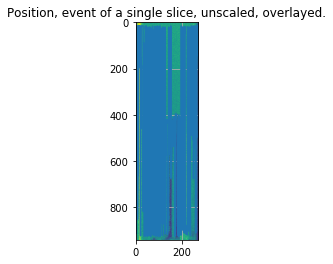

In [121]:
"""Examine profiles for select slice."""
if interactive and not imported:
  scaled_profile, profile = velocity_profile(s, sigma=3,
                                             cube=cube, lengths=lengths)
  plt.title("Position, event of a single slice, unscaled, overlayed.")
  plt.plot(*profile)
  plt.imshow(smoothed)
  plt.grid()
  plt.show()

In [122]:
"""Grab events for entire PSB"""


def extract_events(cube, recompute=False, path="vs", experiment=experiment,
                   **kwargs):
  try:
    if recompute:
      raise
    vs = np.load("npy/{}_{}.npy".format(path, experiment),
                 allow_pickle=True)
  except:
    kwargs["cube"] = cube
    pool = multiprocessing.Pool()
    vs = pool.map(ProcessContext(velocity_profile,**kwargs),
                  range(cube.shape[1]))
    pool.close()
    del pool
    vs = np.array(list(zip(*vs)))
    np.save("npy/{}_{}".format(path, experiment), vs)
  return vs


if not imported:
  vs = extract_events(cube, recompute=True, path="vs", lengths=lengths)

/home/dylan/results/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars
/home/dylan/results/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/home/dylan/results/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars
/home/dylan/results/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


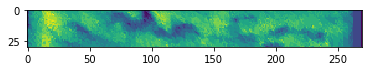

In [23]:
"""Choose a particular psb from the sheared images."""
if interactive and not imported:
  # Check out our slice

  ## Play with cropping values here, and record in experiments
  ## definition in cell #3
  # width = 30
  # start =  390

  ## It may also be desireable to overwrite the band # here for quick
  ## iteration.
  # band = 1

  # plt.imshow(cube[-1, start:start + width, :])
  plt.imshow(cube[-1, start:start + width])
  plt.show()

In [123]:
"""Massage and filter data for extreme outliers."""


def split_vs(vs, start=start, width=width):
  # Parse vs into scaled and unscaled parts.
  scaled = vs[0, start:start + width, :, :]
  unscaled = vs[1, start:start + width, :, :]
  return scaled, unscaled


def flatten(v):
  return np.array(list(zip(*sum([list(zip(*sl)) for sl in v], []))))


def filter_slices(xy,
                  ab,
                  time_margin=time_margin,
                  times=times,
                  lower=None,
                  upper=None):
  if not lower:
    lower = times[time_margin]
  if not upper:
    upper = times[-time_margin]
  return ab.T[np.all([xy[1, :] > lower, xy[1, :] < upper], axis=0)].T


def extract_points(scaled, unscaled,
                   times=times,
                   time_margin=time_margin,
                   beam_width=beam_width,
                   width=width):
  points = flatten(scaled)
  points_raw = flatten(unscaled)
  lin = np.linspace(0, np.max(points[0]), beam_width)
  indices = np.tile(list(range(beam_width)), width)

  indices = filter_slices(points, indices, time_margin=time_margin, times=times)
  points_raw = filter_slices(points, points_raw, time_margin=time_margin, times=times)
  points = filter_slices(points, points, time_margin=time_margin, times=times)
  return lin, indices, points, points_raw


if not imported:
  scaled, unscaled = split_vs(vs)
  lin, indices, points, points_raw = extract_points(scaled, unscaled)
  # Average said events for a representation of event occurence
  # within an entire PSB.
  XY = np.mean(scaled, axis=0)
  raw = np.mean(unscaled, axis=0)

In [124]:
"""Extract the minimum events for an entire band."""


def extract_convexhull(images,
                       points,
                       points_raw,
                       indices,
                       time_margin=time_margin,
                       beam_width=beam_width):
  convex_hull = [
      min(list(points[1][indices == i]) + [list(images.keys())[-time_margin]])
      for i in range(beam_width)
  ]
  convex_hull_raw = [
      min(list(points_raw[1][indices == i]) + [len(images) - time_margin])
      for i in range(beam_width)
  ]
  return convex_hull, convex_hull_raw


if not imported:
  convex_hull, convex_hull_raw = extract_convexhull(images, points, points_raw,
                                                    indices)

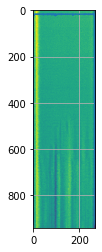

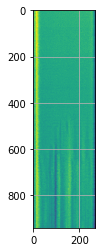

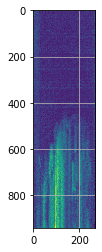

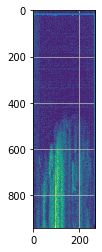

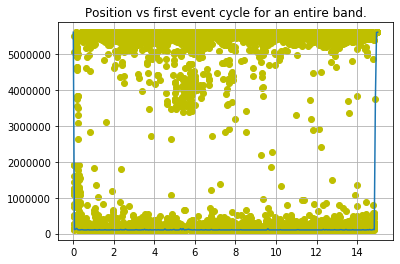

In [125]:
%%skip $imported
# The velocity of a given nucleation should be slope^-1
# A nucleation event should be early, so we expect we can see these as
#
#   \     /
#  S \   / Q
#     \ /
#      v
#
# Where S^-1 would be speed of the left front, and Q^-1, the speed of the
# right front.
#
# It's worth noting, that mean may be incorrect. Each segment may have a
# different length. Depending on where the PSB was chosen, you may have to
# adjust for size considerations. However, with a small band they should only
# vary slightly. So this provides a general idea regardless

plt.imshow(np.mean(cube[:, start:start + width, :], axis=1))
plt.plot(raw[0, :], np.array(convex_hull_raw))
plt.savefig("svg/band{}_{}.svg".format(experiment, band))
plt.grid()
plt.show()
plt.imshow(np.mean(cube[:, start:start + width, :], axis=1))
plt.grid()
plt.show()
plt.imshow(np.std(cube[:, start:start + width, :], axis=1))
plt.grid()
plt.show()
plt.imshow(np.std(cube[:, start:start + width, :], axis=1))
plt.plot(raw[0, :], convex_hull_raw)
plt.grid()
plt.show()
plt.title("""Position vs first event cycle for an entire band.""") 
plt.plot(points[0], points[1], "oy", zorder=-1)
plt.plot(lin, convex_hull)
plt.grid(True)
plt.show()

np.savetxt("csv/dump_{}_band_{}.csv".format(experiment, band), np.array([lin, convex_hull]).T, delimiter=",")

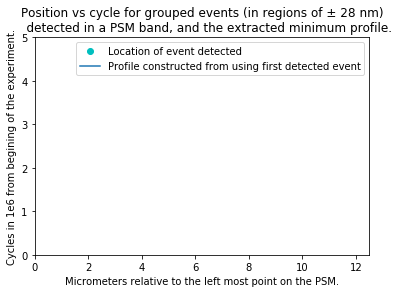

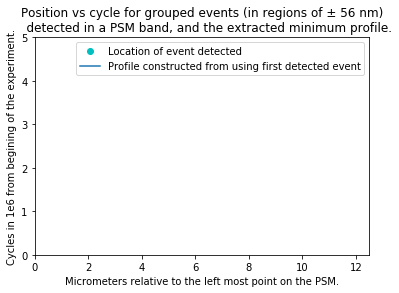

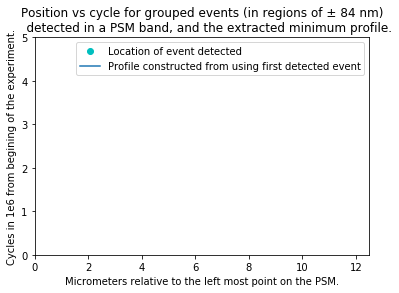

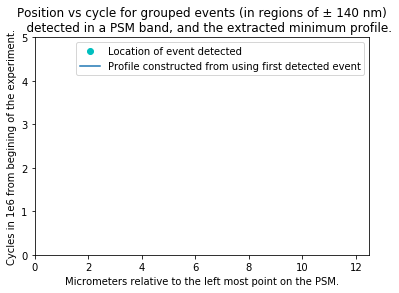

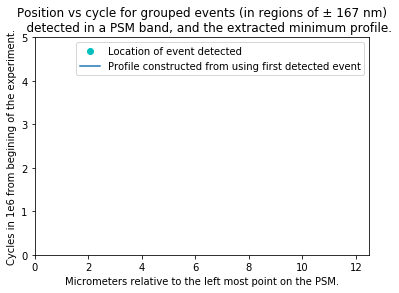

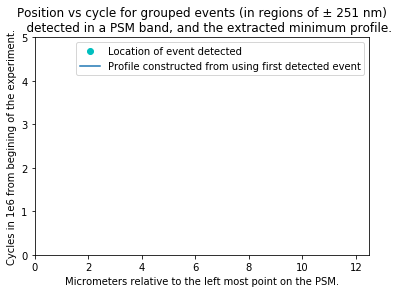

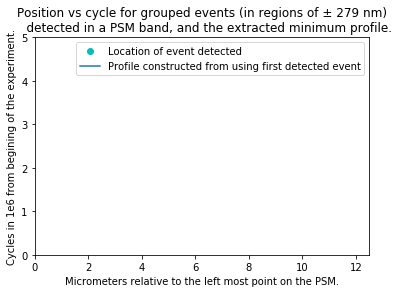

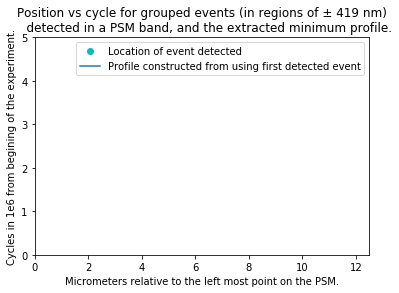

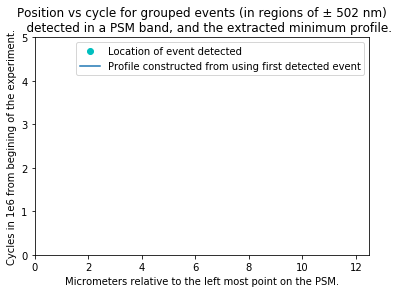

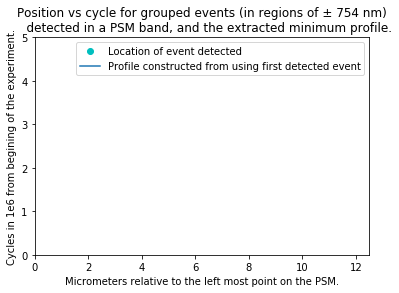

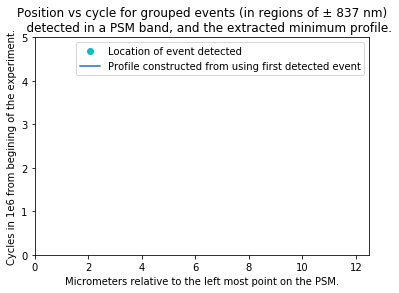

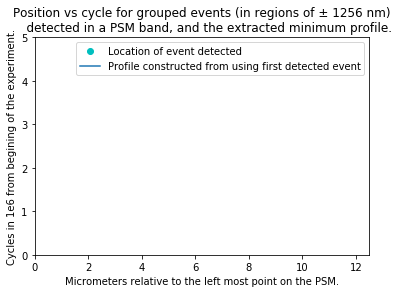

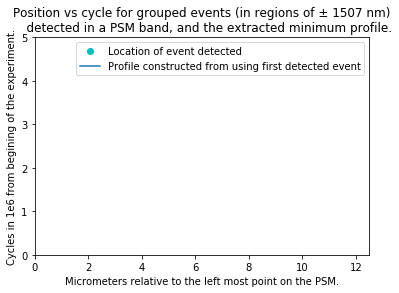

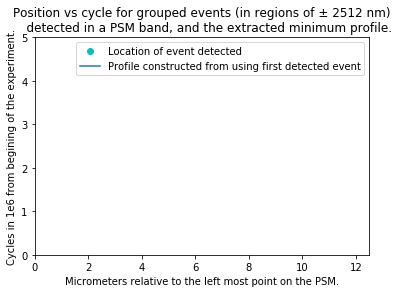

In [27]:
"""By using bucketing as a noise reduction technique, we ensure that the general shape of
the profile is not compromised while reducing event detection mistakes."""


def make_smooth_profile(bucket,
                        images,
                        scaled,
                        unscaled,
                        plotted=True,
                        times=times,
                        width=width,
                        experiment=experiment,
                        band=band,
                        time_margin=time_margin,
                        study_name=None):
  """Groups all terms into 'bucket' sized groups and then performs aggregation."""
  if not study_name: study_name = ""
  scaled_temp = np.min(np.reshape(scaled, [width, 2, bucket, -1]), axis=-1)
  unscaled_temp = np.min(np.reshape(unscaled, [width, 2, bucket, -1]), axis=-1)

  points = flatten(scaled_temp)
  points_raw = flatten(unscaled_temp)
  lin = np.linspace(0, np.max(points[0]), bucket)
  indices = np.tile(list(range(bucket)), width)

  indices = filter_slices(points, indices, time_margin=time_margin, times=times)
  points_raw = filter_slices(points, points_raw, time_margin=time_margin, times=times)
  points = filter_slices(points, points, time_margin=time_margin, times=times)
  points = np.array([points[1], points[0]])
  indices = filter_slices(points, indices, upper=15, lower=2.5)
  points = filter_slices(points, points, upper=15, lower=2.5)
  points = np.array([points[1], points[0]])

  convex_hull = [
      min(list(points[1][indices == i]) + [list(images.keys())[-time_margin]]) /
      1e6 for i in range(bucket)
  ]

  np.savetxt(
      "csv/dump_{}_band_{}_bucket_{}{}.csv".format(experiment, band,
                                                 beam_width // bucket, study_name),
      np.array([lin, convex_hull]).T,
      delimiter=",")
  if plotted:
    plt.title(
        """Position vs cycle for grouped events (in regions of ± {:.0f} nm)
    detected in a PSM band, and the extracted minimum profile.""".format(
            1e3 * (beam_width // bucket) * (scale / lengths[start]) / 2))
    plt.plot(
        points[0] - 2.5,
        points[1] / 1e6,
        "oc",
        label="Location of event detected",
        zorder=-1)
    plt.plot(
        lin - 2.5,
        convex_hull,
        label="Profile constructed from using first detected event")
    plt.ylabel("""Cycles in 1e6 from begining of the experiment.""")
    plt.xlabel("""Micrometers relative to the left most point on the PSM.""")
    plt.xlim(0, 12.5)
    plt.ylim(0, 5)
    plt.legend()
    plt.savefig("svg/band{}_{}__bucket_{}.svg".format(experiment, band,
                                                      beam_width // bucket))
    plt.show()


def factors(n):
  """A nice way to generate the factors of a number."""
  r = np.arange(1, int(n**0.5) + 1)
  x = r[np.mod(n, r) == 0]
  return list(sorted(np.concatenate((x, n // x), axis=None), reverse=True))


def export_profiles(images,
                    scaled,
                    unscaled,
                    plotted=True,
                    times=times,
                    beam_width=beam_width,
                    width=width,
                    experiment=experiment,
                    band=band,
                    time_margin=time_margin,
                    study_name=None):
  # The final 2 factors produce useless plots, thus we ignore them
  for factor in factors(beam_width)[:-2]:
    make_smooth_profile(
        factor,
        images,
        scaled,
        unscaled,
        plotted=plotted,
        times=times,
        width=width,
        experiment=experiment,
        band=band,
        time_margin=time_margin,
        study_name=study_name)


if not imported:
  export_profiles(
      images,
      scaled,
      unscaled,
      plotted=True,
      width=width,
      experiment=experiment,
      band=band,
      time_margin=time_margin)

In [28]:
"""Extract a time/displacement graph for a segment in the profile."""


def filter_segment(xy, ab, lower=5, upper=8):
  ab = ab[:, np.all([xy[0, :] > lower, xy[0, :] < upper], axis=0)]
  return ab


def fit_segment(xy, lower=5, upper=8, right=False, preserve=False, plot=True):
  # Crop to the segement of the band
  xy = filter_segment(xy, xy, lower=lower, upper=upper)

  npmax, npmin = np.max, np.min
  if right:
    npmax, npmin = np.min, np.max

  # Adjust so t=0 is nucleation event
  if not preserve:
    xy[1, :] -= np.min(xy[1, :])

  # Adjust so displacement is positivly relative to displacement
  if not preserve:
    xy[0, :] -= npmax(xy[0, :])

  if not right and not preserve:
    xy[0, :] *= -1

  # Swap, because displacement time graph, should be displacement v time.
  xy = np.array([xy[1, :], xy[0, :]])

  # Provide a linear fit.
  fit = np.polyfit(xy[0, :], xy[1, :], 1)
  fit_fn = np.poly1d(fit)

  M = np.max(xy[0, :])
  X = np.arange(0, M, M / 48)
  if plot:
    plt.title("Displacement/Velocity for {}, band {}.".format(experiment, band))
    plt.xlabel("Cycles since start of Nucleation")
    plt.ylabel(u"Propogation distance from Nucleation site (μm).")
    plt.plot(xy[0, :], xy[1, :], 'bo', X, fit_fn(X), '--k')
    plt.savefig("svg/speed{}_{}.svg".format(experiment, band))
    plt.show()
  return scipy.stats.linregress(*xy)


if not imported:
  line = fit_segment(
      np.array([lin, convex_hull]), lower=lower, upper=upper, right=False)
  line

/home/dylan/results/virtualenv/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [ ]:
"""Determine a likely embryo from the fit of the profile to randomness."""


def embryo(xy, dx=.1, lower=2.5, upper=15, debug=False, plot=True):
  """Determines embyronic width of a profile.
  Starting with the lowest point on the profile, determines if a
  collection of points is likely random by comparion to gassian distribution.
  The collection is then expanded by the surrounding lowest points.
  
  Args:
      xy: The profile to consider
      dx: The gradation step to take when expanding front
      lower: The lower bound on the profile to be considered.
      upper: The upper bound on the profile to be considered.
      debug: Produce additional plots and logs
      plot: Produce plot for randomness metrics

  Returns:
      tuple of embyro start, embyro end, embryo length, standard deviation, r^2 in embryo
  """
  gradations = np.arange(dx, 100, dx)
  xy = filter_segment(xy, xy, lower=lower, upper=upper)
  line_xy = filter_segment(xy, xy, lower=5, upper=12)
  xy = np.array([xy[1, :], xy[0, :]])
  line_xy = np.array([line_xy[1, :], line_xy[0, :]])
  line = fit_segment(line_xy, lower=0, upper=np.max(line_xy), plot=debug)
  if debug:
    print(line, np.min(xy[0, :]))
  pps = None
  if debug:
    pps = pylab

  def f(e):
    gaussian = filter_segment(
        xy, xy, lower=0, upper=np.min(xy[0, :]) + line.stderr * e)
    _, (c, i, rSquared) = probplot(gaussian[0, :], dist='norm', plot=pps)
    return rSquared

  rs = np.array(list(map(f, gradations)))
  selection = np.argmax(rs)
  if plot:
    plt.show()
    plt.title("""Randomness Metric
(negative log of 1 - r^2 from P-P plot)
over profile.""")
    plt.ylabel("Randomness metric")
    plt.xlabel("% of profile considered")
    plt.plot(gradations, -np.log(1 - rs))
    plt.savefig("svg/random{}_{}.svg".format(experiment, band))
    plt.show()
    plt.title("r^2 value of potential embryo vs. Gaussian distribution")
    plt.ylabel("r^2")
    plt.xlabel("% of profile considered")
    plt.plot(gradations, rs)
    plt.show()
    np.savetxt(
        "csv/randomraw_{}_band_{}.csv".format(experiment, band),
        np.array([gradations, rs]).T,
        delimiter=",")
    print(selection)

  std = gradations[selection] * line.stderr
  f(gradations[np.argmax(rs)])
  filt = filter_segment(xy, xy, lower=0, upper=np.min(xy[0, :]) + std)[1, :]
  plt.close("all")
  return np.min(filt), np.max(filt), np.max(filt) - np.min(filt), std, np.max(
      rs)


if not imported:
  print(
      """{2:.2f} micrometer long embyro spanning from position {0:.2f} to {1:.2f},
correlated to Gaussian noise with an r^2 of {4:.3f}""".format(
          *embryo(np.array([lin, convex_hull]), lower=2.5, upper=16.5)))